In [1416]:
import pandas as pd
import geopandas as gp 
import json
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(12,8)})
%matplotlib inline
from tqdm import tqdm
import glob
import numpy as np

In [1417]:
files = glob.glob('../BL_Work/openPrescribe/serialized/*.gz')
print files

['../BL_Work/openPrescribe/serialized/201009.gz', '../BL_Work/openPrescribe/serialized/201008.gz', '../BL_Work/openPrescribe/serialized/201011.gz', '../BL_Work/openPrescribe/serialized/201010.gz', '../BL_Work/openPrescribe/serialized/201012.gz']


In [1418]:
pdp = pd.read_csv(files[0])

In [1419]:
patients = pd.read_csv('../BL_Work/grondTruths/gp-reg-patients-04-2013.csv')

In [1420]:
patients = patients.dropna()

In [1421]:
# patients[pd.isna(patients['TOTAL_ALL'])]

In [1422]:
pdp.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,Q30,5D7,A86001,0501013B0AAAJAJ,Amoxicillin_Oral Susp 125mg/5ml,1.0,1.69,1.59,100.0,201009.0,NE6 1SG,NaN,NaN,NaN,NaN
1,1,Q30,5D7,A86003,0101010G0AAABAB,Co-Magaldrox_Susp 195mg/220mg/5ml S/F,44.0,124.96,116.45,25800.0,201009.0,NE1 8DQ,NaN,NaN,NaN,NaN
2,2,Q30,5D7,A86003,0101010G0BBABAB,Maalox_Susp 195mg/220mg/5ml S/F,1.0,5.58,5.17,1000.0,201009.0,NE1 8DQ,NaN,NaN,NaN,NaN
3,3,Q30,5D7,A86003,0101010G0BCABAB,Mucogel_Susp 195mg/220mg/5ml S/F,1.0,1.71,1.61,500.0,201009.0,NE1 8DQ,NaN,NaN,NaN,NaN
4,4,Q30,5D7,A86003,0101010L0BBABAA,Asilone_Susp S/F,1.0,1.95,1.83,500.0,201009.0,NE1 8DQ,NaN,NaN,NaN,NaN


In [1423]:
practice_patient_dict = {}
for index , row in patients.iterrows():
    practice_patient_dict[row['GP_PRACTICE_CODE']] = row['TOTAL_ALL']

In [1424]:
# practice_patient_dict

In [1425]:
prevalence_df = pd.read_csv('../BL_Work/grondTruths/PREVALENCE.csv')

In [1427]:
diseaseMatched = json.load(open('../processed/DiseasesMatched.json','rb'))

In [1428]:
# diseaseMatched.keys()

In [1429]:
%store -r Drug_code

In [1430]:
Drug_code

{'0101010M0': {'disease': u'kidney stones',
  'disease_given_drug': 0.007575757575757576,
  'name': 'Magaldrate'},
 '0102000AB': {'disease': u'irritable bowel syndrome',
  'disease_given_drug': 0.0036199095022624436,
  'name': 'Hyoscyamine Sulphate'},
 '0102000AD': {'disease': u'irritable bowel syndrome',
  'disease_given_drug': 0.008429926238145416,
  'name': 'Pinaverium Bromide'},
 '0102000AG': {'disease': u'irritable bowel syndrome',
  'disease_given_drug': 0.10238095238095238,
  'name': 'Tegaserod Maleate'},
 '0103010S0': {'disease': u'rheumatoid',
  'disease_given_drug': 0.09,
  'name': 'Ranitidine Bismuth Citrate'},
 '0103010T0': {'disease': u'rheumatoid',
  'disease_given_drug': 0.09,
  'name': 'Ranitidine Hydrochloride'},
 '0104020D0': {'disease': u'diabetes',
  'disease_given_drug': 0.3229166666666667,
  'name': 'Codeine Phosphate Compound Mixtures'},
 '0105010B0': {'disease': u"crohn's disease",
  'disease_given_drug': 0.15555555555555556,
  'name': 'Mesalazine (Systemic)'},


In [1431]:
def diseasePrevalence( disease_presc, practice_population, drug_prob , totalDrugs):
    diseaseGP_prevalence= []
    for name , group in disease_presc.groupby('3'):
        for code in drug_prob:
            if code in name:
#                 prev = (float(len(group))/float(practice_population+1)) * drug_prob[code]['disease_given_drug']
#                 print len(group) , totalDrugs
#                 prev = ((float(float(len(group))/float(totalDrugs)))* drug_prob[code]['disease_given_drug'])*practice_population
                prev = ((float(float(len(group))/float(totalDrugs)))* drug_prob[code]['disease_given_drug'])
                diseaseGP_prevalence.append(prev)
    return float(np.sum(diseaseGP_prevalence))#/practice_population




In [1432]:
presc_Disease_prevalence = {}
missing_pract = []
for f in tqdm(files[:-1]):
    month = f.split('/')[-1].split('.')[0]
    print "Working with %s month"%(month)
    presc_Disease_prevalence[month] = {}
    pdp = pd.read_csv(f,compression='gzip')
    print "there are in total %d practices in this file"%(len(set(pdp['2'])))
    pdp['10']= pdp['10'].str.split(' ', n = 1, expand = True)
    
#     for d in tqdm(['diabetes','depression','dementia','rheumatoid']):
    for d in tqdm(diseaseMatched):
        key = d.replace('\"','').replace('+',' ').replace('\\','')
        if key not in  presc_Disease_prevalence[month]:
             presc_Disease_prevalence[month][key] = {}
        for name , group in pdp.groupby('2'):
            disease_df = group[group['12'] == key]
            all_diseases = group[group['12'].notnull()]
            total_drugs = len(all_diseases)
            if len(disease_df) == 0:
                presc_Disease_prevalence[month][key][name] = 0.0
            else:
                try :
                    practice_pop =  practice_patient_dict[name.strip()]
                except:
                    missing_pract.append(name)
                    continue
                presc_Disease_prevalence[month][key][name] = diseasePrevalence (disease_df , practice_pop ,Drug_code , total_drugs)
           

  0%|          | 0/4 [00:00<?, ?it/s]

Working with 201009 month
there are in total 10265 practices in this file



 25%|██▌       | 1/4 [12:55<38:47, 775.84s/it]

Working with 201008 month
there are in total 10264 practices in this file



 50%|█████     | 2/4 [25:26<25:26, 763.49s/it]

Working with 201011 month
there are in total 10269 practices in this file



 75%|███████▌  | 3/4 [38:00<12:40, 760.28s/it]

Working with 201010 month
there are in total 10265 practices in this file



100%|██████████| 4/4 [50:25<00:00, 756.26s/it]


In [1433]:
%store  -r compre_postCode_dict
compre_postCode_dict

{'Adur': {'areaId': ['E07000223'],
  'postcodes': ['BN41', 'BN15', 'BN14', 'BN42', 'BN43']},
 'Allerdale': {'areaId': ['E07000026'],
  'postcodes': ['CA13', 'CA15', 'CA14', 'CA7', 'CA12', 'CA5']},
 'Amber Valley': {'areaId': ['E07000032'],
  'postcodes': ['DE4',
   'DE22',
   'DE21',
   'DE5',
   'NG16',
   'DE6',
   'DE56',
   'DE55',
   'DE75',
   'DE7']},
 'Arun': {'areaId': ['E07000224'],
  'postcodes': ['BN18',
   'BN17',
   'BN16',
   'BN14',
   'BN13',
   'BN12',
   'PO21',
   'PO18',
   'PO20',
   'PO22']},
 'Ashfield': {'areaId': ['E07000170'],
  'postcodes': ['NG16', 'NG17', 'NG6', 'NG15', 'DE55', 'NG18', 'NG19']},
 'Ashford': {'areaId': ['E07000105'],
  'postcodes': ['CT4',
   'TN30',
   'TN17',
   'TN18',
   'ME13',
   'ME17',
   'TN23',
   'TN24',
   'TN25',
   'TN26',
   'TN27']},
 'Aylesbury Vale': {'areaId': ['E07000004'],
  'postcodes': ['HP19',
   'HP18',
   'HP17',
   'HP16',
   'MK19',
   'MK18',
   'OX9',
   'OX5',
   'MK17',
   'HP4',
   'OX33',
   'OX27',
   'HP2

In [1434]:
# json.dump(presc_Disease_prevalence,open('Conditional_GP_disease_prevalence.json','wb'))

In [1436]:
# old way = json.load(open('Conditional_GP_disease_prevalence.json','wb'))

In [1383]:
pdp = pd.read_csv(files[-1],compression='gzip')

In [1384]:
GP_postcodes = {}
for name , group in pdp.groupby('2'):
    postcode = list(set(group['10']))
    GP_postcodes[name] = str(postcode[0]).split(' ')[0]
        

In [1385]:
presc_Disease_prevalence.keys()

['201009', '201008']

In [1388]:
filtered = [k for k in presc_Disease_prevalence['201009']['depression'].values() if not np.isnan(k)]

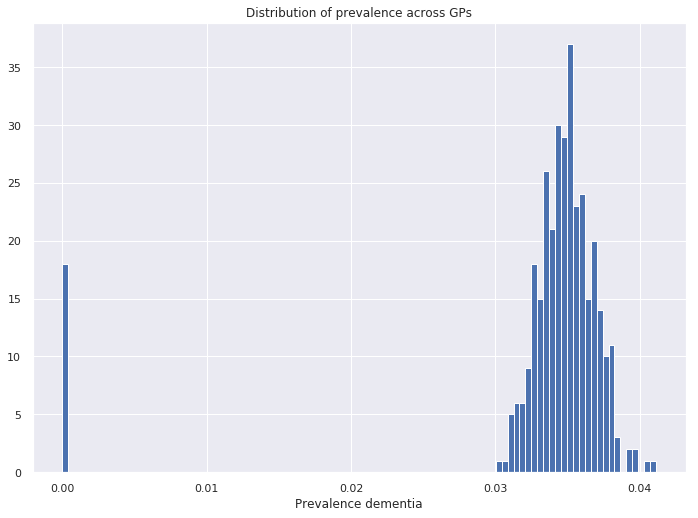

In [1389]:
plt.hist(filtered,bins=100)
ax = plt.gca()
ax.set_title("Distribution of prevalence across GPs")
ax.set_xlabel("Prevalence dementia")
ax.set_ylabel("")

In [1390]:
# pd.Series(filtered, name="Prevalence diabetes")
# sns.distplot(filtered)
# ax = plt.gca()
# ax.set_title("Distribution of prevalence across GPs")
# ax.set_xlabel("Prevalence")
# ax.set_ylabel("")

In [1392]:
disease_GP_level = {}
# for k in presc_Disease_prevalence.keys():
for k in ['201009']:
    diabetes = presc_Disease_prevalence[k]['depression']
    for gp_id in diabetes:
        if gp_id not in disease_GP_level:
            disease_GP_level[gp_id] = []
        disease_GP_level[gp_id].append(diabetes[gp_id])

        

In [1393]:
disease_GP_level

{'Adur': [0.03682232438857025],
 'Allerdale': [0.037965224433623206],
 'Amber Valley': [0.0349909070288805],
 'Arun': [0.03362161664942548],
 'Ashfield': [0.034353048114082886],
 'Ashford': [0.034548905667642016],
 'Aylesbury Vale': [0.03369416633615125],
 'Babergh': [0.03495545401468271],
 'Barking and Dagenham': [0.0333316885653121],
 'Barnet': [0.03348994061186751],
 'Barnsley': [0.035627595687268754],
 'Barrow-in-Furness': [0.03586327911381453],
 'Basildon': [0.03389638098209275],
 'Basingstoke and Deane': [0.03636378538333861],
 'Bassetlaw': [0.03178588283527959],
 'Bath and North East Somerset': [0.034953683038176406],
 'Bedford': [0.03280068236238662],
 'Bexley': [0.0314690281357843],
 'Birmingham': [0.03430453596469543],
 'Blaby': [0.03321772136301854],
 'Blackburn with Darwen': [0.033798582106615856],
 'Blackpool': [0.03697683804140925],
 'Blaenau Gwent': [0.0],
 'Bolsover': [0.03344638749840615],
 'Bolton': [0.03553959848412752],
 'Boston': [0.033646356013719056],
 'Bournemou

In [1366]:
groundTruth = pd.read_csv('../BL_Work/prevalence/MH.csv')

In [1367]:
groundTruth.head()

,Unnamed: 0,disease_prevalence,postcode,practice_code,registered
0,0,0.007341,TS18 2AW,A81002,19887
1,1,0.006440,TS1 3BE,A81004,9472
2,2,0.010719,TS14 7DJ,A81005,7930
3,3,0.009174,TS18 2AT,A81006,13734
4,4,0.006841,TS24 7PW,A81007,9940


In [1368]:

gt = []
presc = []
for index , row in groundTruth.iterrows():
    if not np.isnan(row['disease_prevalence']):
        if row['practice_code'] in disease_GP_level:
            gt.append(row['disease_prevalence'])
            presc.append(np.mean(disease_GP_level[row['practice_code'] ]))

In [1369]:
# gt

In [1370]:
from scipy.stats import pearsonr
pearsonr(presc,gt)

(0.4040739768668964, 8.174521600277e-284)

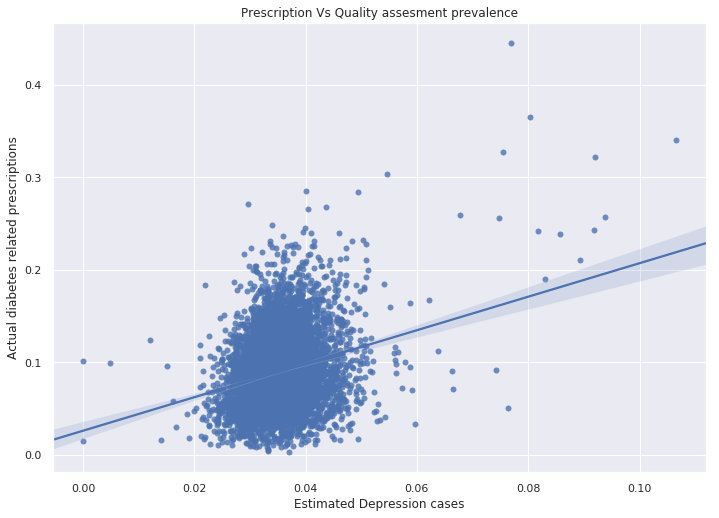

In [1301]:
sns.regplot(x=presc , y = gt)
ax = plt.gca()
ax.set_title("Prescription Vs Quality assesment prevalence")
ax.set_xlabel("Estimated Depression cases")
ax.set_ylabel("Actual diabetes related prescriptions")

In [1302]:
 pdp = pd.read_csv(f,compression='gzip')

In [1303]:
# %store -r postCodeDict
%store  -r compre_postCode_dict

In [1304]:
postCodeDict = compre_postCode_dict

In [1305]:
# postCodeDict

In [1306]:
GP_postcodes

{'E84702': 'NW2',
 'Y03108': 'HU9',
 'E84701': 'HA0',
 'E84706': 'NW9',
 'E84707': 'HA3',
 'E84704': 'NW2',
 'E84705': 'NW10',
 'Y03101': 'L12',
 'E84708': 'NW10',
 'E84709': 'HA9',
 'Y03105': 'TW15',
 'Y02796': 'CM2',
 'Y03106': 'SE7',
 'Y02795': 'M24',
 'Y00857': 'SW17',
 'Y02066': 'DH1',
 'B85014': 'WF16',
 'B85015': 'WF17',
 'B85016': 'HD1',
 'B85010': 'HD5',
 'B85011': 'HD7',
 'B85012': 'WF16',
 'Y02794': 'B8',
 'B85018': 'WF17',
 'B85019': 'WF14',
 'Y03104': 'NG12',
 'N81032': 'CW11',
 'N81033': 'SK9',
 'N81030': 'WA6',
 'N81031': 'CW6',
 'N81036': 'WA2',
 'N81037': 'WA8',
 'N81034': 'CH2',
 'N81035': 'WA8',
 'N81038': 'SY14',
 'N81039': 'CW10',
 'Y00855': 'CM7',
 'N82046': 'L15',
 'Y02068': 'BB2',
 'N82041': 'L13',
 'N82048': 'L9',
 'N82049': 'L4',
 'G82162': 'ME8',
 'G82163': 'DA12',
 'G82160': 'CT21',
 'G82161': 'ME5',
 'Y00100': 'BD18',
 'Y00453': 'PL6',
 'G82164': 'ME16',
 'G82165': 'CT4',
 'G82168': 'ME7',
 'Y00108': 'NG2',
 'Y00458': 'B61',
 'M83719': 'WS12',
 'Y01851': 'W

In [1307]:
area_patients = {}
for k in GP_postcodes:
    postCode = GP_postcodes[k]
    for area in postCodeDict:
        if postCode in postCodeDict[area]['postcodes']:
            try:
                if area not in area_patients:
                    area_patients[area] = practice_patient_dict[k]
                else:
                    area_patients[area] += practice_patient_dict[k]
            except:
                continue

area_patients_filtered = {k: area_patients[k] for k in area_patients if not np.isnan(area_patients[k] )}

In [1308]:
len(area_patients_filtered)

330

In [1309]:
area_patients_filtered

{'Adur': 129092.0,
 'Allerdale': 108455.0,
 'Amber Valley': 384186.0,
 'Arun': 248224.0,
 'Ashfield': 350530.0,
 'Ashford': 234340.0,
 'Aylesbury Vale': 471390.0,
 'Babergh': 166878.0,
 'Barking and Dagenham': 269894.0,
 'Barnet': 718208.0,
 'Barnsley': 427411.0,
 'Barrow-in-Furness': 93269.0,
 'Basildon': 287058.0,
 'Basingstoke and Deane': 330428.0,
 'Bassetlaw': 232023.0,
 'Bath and North East Somerset': 259659.0,
 'Bedford': 354363.0,
 'Bexley': 379004.0,
 'Birmingham': 1379549.0,
 'Blaby': 536278.0,
 'Blackburn with Darwen': 264954.0,
 'Blackpool': 223882.0,
 'Bolsover': 315714.0,
 'Bolton': 446977.0,
 'Boston': 155806.0,
 'Bournemouth': 199763.0,
 'Bracknell Forest': 297901.0,
 'Bradford': 645630.0,
 'Braintree': 353920.0,
 'Breckland': 236225.0,
 'Brent': 693223.0,
 'Brentwood': 131574.0,
 'Brighton and Hove': 301501.0,
 'Bristol, City of': 603527.0,
 'Broadland': 301051.0,
 'Bromley': 535014.0,
 'Bromsgrove': 557653.0,
 'Broxbourne': 173028.0,
 'Broxtowe': 208216.0,
 'Burnley':

In [1310]:
filteredGPs = list(set(disease_GP_level.keys()).intersection(GP_postcodes.keys()))
len(filteredGPs)

9467

In [1311]:
area_prevalence = {}
GP_Disease_cases = {}
GP_registerd_patients = {}
GP_patients_per_GP = {}
for k in filteredGPs:
    postCode = GP_postcodes[k]
    for area in area_patients_filtered:
        if area not in area_prevalence:
            area_prevalence[area]= {}
            area_prevalence[area]['GP'] = []
            GP_Disease_cases[area] = []
            GP_registerd_patients[area] = []
        if postCode in postCodeDict[area]['postcodes']:
            if not np.isnan(disease_GP_level[k][0]) and k in practice_patient_dict:
                area_prevalence[area]['GP'].append(float(disease_GP_level[k][0])*float(practice_patient_dict[k]))
                GP_Disease_cases[area].append(disease_GP_level[k][0])
                GP_registerd_patients[area].append(practice_patient_dict[k])
for area in area_prevalence:
    area_prevalence[area]['norm'] = float(np.sum(area_prevalence[area]['GP']))/float(area_patients_filtered[area]+1)
    GP_patients_per_GP[area] =     float(area_patients_filtered[area])/len(area_prevalence[area]['GP'])
        

In [1394]:
# area_prevalence = presc_Disease_prevalence_area['201012']['depression']

In [1395]:
area_prevalence['Westminster']

0.03846095179469115

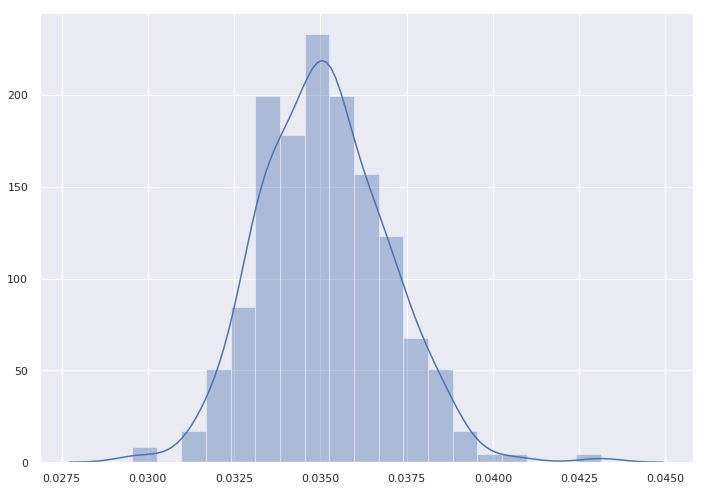

In [1313]:
sns.distplot([area_prevalence[k]['norm'] for k in area_prevalence ])

In [1396]:
Area_Gt = pd.read_csv('../BL_Work/prevalence_LA_level/DEP_LA_level.csv')

In [1397]:
Area_Gt[Area_Gt['Area'] == 'City of London']

,Unnamed: 0,Area,weighted_mean
244,244,City of London,0.066618


In [1398]:
area_prevalence['City of London']

0.037583539295083054

In [1399]:
%store -r lon_boro

In [1400]:
set(area_prevalence.keys()).intersection(Area_Gt['Area'])

{'Adur',
 'Allerdale',
 'Amber Valley',
 'Arun',
 'Ashfield',
 'Ashford',
 'Aylesbury Vale',
 'Babergh',
 'Barking and Dagenham',
 'Barnet',
 'Barnsley',
 'Barrow-in-Furness',
 'Basildon',
 'Basingstoke and Deane',
 'Bassetlaw',
 'Bath and North East Somerset',
 'Bedford',
 'Bexley',
 'Birmingham',
 'Blaby',
 'Blackburn with Darwen',
 'Blackpool',
 'Blaenau Gwent',
 'Bolsover',
 'Bolton',
 'Boston',
 'Bournemouth',
 'Bracknell Forest',
 'Bradford',
 'Braintree',
 'Breckland',
 'Brent',
 'Brentwood',
 'Bridgend',
 'Brighton and Hove',
 'Bristol, City of',
 'Broadland',
 'Bromley',
 'Bromsgrove',
 'Broxbourne',
 'Broxtowe',
 'Burnley',
 'Bury',
 'Caerphilly',
 'Calderdale',
 'Cambridge',
 'Camden',
 'Cannock Chase',
 'Canterbury',
 'Cardiff',
 'Carlisle',
 'Carmarthenshire',
 'Castle Point',
 'Central Bedfordshire',
 'Ceredigion',
 'Charnwood',
 'Chelmsford',
 'Cheltenham',
 'Cherwell',
 'Cheshire East',
 'Cheshire West and Chester',
 'Chesterfield',
 'Chichester',
 'Chiltern',
 'Chorley

In [1402]:
area_prevalence['Westminster']

0.03846095179469115

In [1403]:
GP_Disease_cases['City of London']

[0.03602670732606701,
 0.03629245937025834,
 0.07810249554182243,
 0.03802603807119008,
 0.03884395781281229,
 0.033489448408884834,
 0.035087005077876016,
 0.03421219689333058,
 0.022343467538622014,
 0.03691238842652571,
 0.05029528181513801,
 0.041326895495028604]

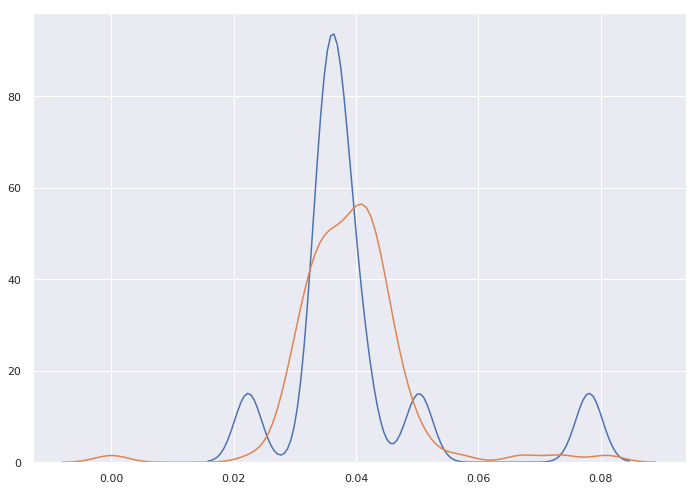

In [1404]:
sns.distplot(GP_Disease_cases['City of London'], hist=False)
sns.distplot(GP_Disease_cases['Westminster'], hist=False)

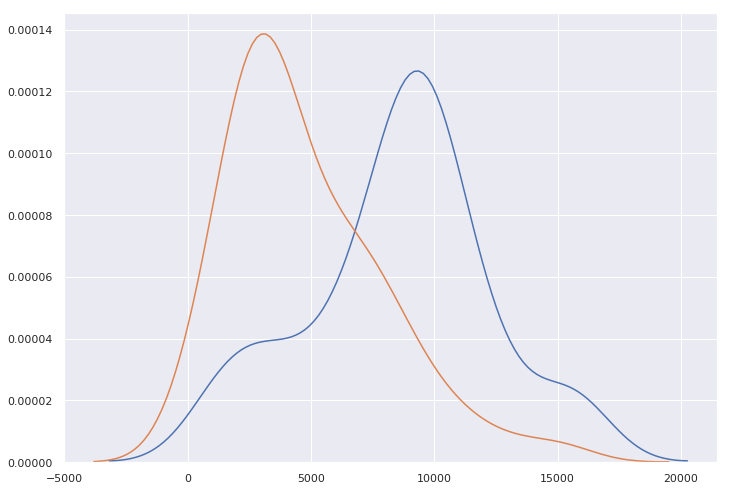

In [1405]:
sns.distplot(GP_registerd_patients['City of London'], hist=False)
sns.distplot(GP_registerd_patients['Westminster'] , hist=False)

In [1407]:
len(area_prevalence['Westminster']['GP'] )

TypeError: object of type 'numpy.float64' has no len()

In [1323]:
GP_registerd_patients['Westminster']

[4421.0,
 10750.0,
 4303.0,
 3086.0,
 6812.0,
 2528.0,
 3164.0,
 12167.0,
 2167.0,
 619.0,
 3213.0,
 271.0,
 234.0,
 1427.0,
 3153.0,
 8216.0,
 6085.0,
 304.0,
 1507.0,
 3269.0,
 4065.0,
 6175.0,
 256.0,
 2562.0,
 6970.0,
 3079.0,
 2330.0,
 5011.0,
 2293.0,
 215.0,
 3635.0,
 7459.0,
 3879.0,
 12885.0,
 4461.0,
 6224.0,
 4493.0,
 7328.0,
 8535.0,
 4755.0,
 1850.0,
 2403.0,
 9516.0,
 3928.0,
 3125.0,
 3215.0,
 2155.0,
 5966.0,
 2903.0,
 1587.0,
 10846.0,
 2913.0,
 7042.0,
 1986.0,
 1822.0,
 5483.0,
 3538.0,
 2738.0,
 3389.0,
 6261.0,
 5899.0,
 7869.0,
 7294.0,
 6932.0,
 3745.0,
 1724.0,
 4858.0,
 2484.0,
 3971.0,
 3118.0,
 1480.0,
 2605.0,
 3601.0,
 3565.0,
 8600.0,
 1626.0,
 5058.0,
 6052.0,
 1413.0,
 5465.0,
 5018.0,
 5359.0,
 8617.0,
 9117.0,
 7541.0,
 14489.0,
 7383.0,
 2175.0,
 3651.0,
 3563.0,
 3045.0,
 1550.0,
 2511.0,
 8665.0,
 6612.0,
 10544.0,
 4189.0,
 9921.0,
 2245.0,
 15484.0,
 8485.0]

In [1324]:
area_patients_filtered['City of London']

102835.0

In [1325]:
# subAreas = list(set(area_prevalence.keys()).intersection(Area_Gt['Area']))
subAreas = lon_boro

In [1408]:
keys=list(set(GP_patients_per_GP.keys()).intersection(lon_boro))
print len(keys)

33


In [1409]:
np.mean([GP_patients_per_GP[k] for k in keys ]) , np.std([GP_patients_per_GP[k] for k in keys ])

(6353.486741525952, 946.0577010914092)

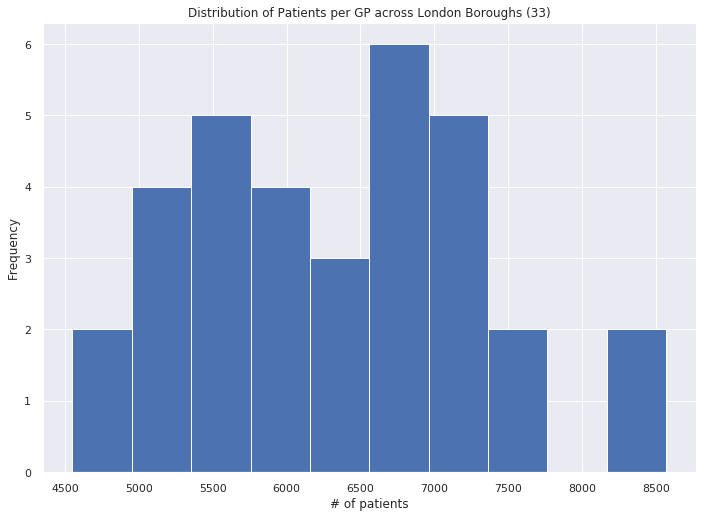

In [1410]:
# sns.distplot([GP_patients_per_GP[k] for k in keys ],bins=33 , hist= False , kde=True)
plt.hist([GP_patients_per_GP[k] for k in keys ],bins=10 )
ax = plt.gca()
ax.set_title("Distribution of Patients per GP across London Boroughs (33)")
ax.set_xlabel("# of patients")
ax.set_ylabel("Frequency")

In [1328]:
Area_Gt.head()

,Unnamed: 0,Area,weighted_mean
0,0,Mendip,0.094943
1,1,Windsor and Maidenhead,0.070575
2,2,Hambleton,0.081599
3,3,Ipswich,0.107000
4,4,Castle Point,0.084568


In [1412]:
predict = []
gt = []
names = []
for index, row in Area_Gt.iterrows():
    if row['Area'].strip() in subAreas:
        if row['weighted_mean'] >= 0: 
#             if area_patients[row['Area'].strip()] > 500000 and area_patients[row['Area'].strip()] < 2000000:
#             if row['Area'] in area_prevalence:
#             predict.append(area_prevalence[row['Area'].strip()]['norm'])
            predict.append(area_prevalence[row['Area']])
            names.append(row['Area'].strip())
            gt.append(row['weighted_mean'])

In [1413]:
pearsonr(predict,gt)

(0.4218275782268664, 0.014480716443617203)

In [1414]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': pd.Series(x), 'y':  pd.Series(y), 'val': pd.Series(val)}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

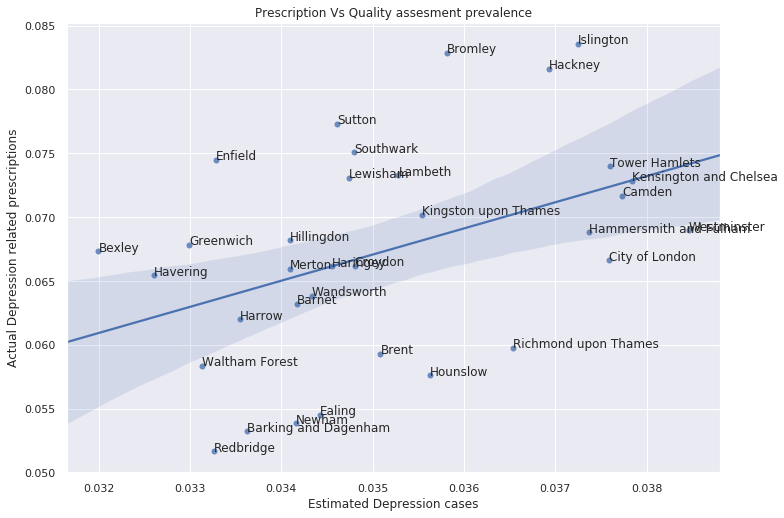

In [1415]:
sns.regplot(x=predict , y = gt)
ax = plt.gca()
label_point(predict , gt , names , ax)
ax.set_title("Prescription Vs Quality assesment prevalence")
ax.set_xlabel("Estimated Depression cases")
ax.set_ylabel("Actual Depression related prescriptions")